In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from keras import layers, regularizers, callbacks, Sequential

In [6]:
DATA_DIR = "./processed_data"

train_df = pd.read_csv(f"{DATA_DIR}/X_train.csv")
val_df   = pd.read_csv(f"{DATA_DIR}/X_val.csv")
test_df  = pd.read_csv(f"{DATA_DIR}/X_test.csv")
y_test   = pd.read_csv(f"{DATA_DIR}/y_test.csv").iloc[:, 0]

# collapse all non-benign labels to generic “Attack”
y_test_bin = (y_test != "Benign").astype(int).values   # 0 = Benign, 1 = Attack

In [7]:
train_benign = train_df[train_df["Label"] == "Benign"]
val_benign   = val_df  [val_df  ["Label"] == "Benign"]

X_train_raw = train_benign.drop(columns=["Label"]).values
X_val_raw   = val_benign.drop(columns=["Label"]).values
X_test_raw  = test_df.values

In [8]:
print("Handle infinite values")
X_train_raw[np.isinf(X_train_raw)] = np.nan
X_val_raw[np.isinf(X_val_raw)] = np.nan
X_test_raw[np.isinf(X_test_raw)] = np.nan

imp = SimpleImputer(strategy="median").fit(X_train_raw)
X_train_imp = imp.transform(X_train_raw)
X_val_imp   = imp.transform(X_val_raw)
X_test_imp  = imp.transform(X_test_raw)

scaler = MinMaxScaler().fit(X_train_imp)
X_train = scaler.transform(X_train_imp)
X_val   = scaler.transform(X_val_imp)
X_test  = scaler.transform(X_test_imp)
print(f"Train shape: {X_train.shape}   Val: {X_val.shape}   Test: {X_test.shape}")


Handle infinite values
Train shape: (204896, 62)   Val: (8882, 62)   Test: (118585, 62)


In [9]:
input_dim = X_train.shape[1]          # 62
auto = Sequential([
    layers.Input((input_dim,)),
    layers.Dense(48, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(24, activation="relu",
                 activity_regularizer=regularizers.l1(1e-5)),
    layers.Dense(12, activation="relu"),          # bottleneck
    layers.Dense(24, activation="relu"),
    layers.Dense(48, activation="relu"),
    layers.Dense(input_dim, activation="linear")
], name="autoencoder")

auto.compile(optimizer="adam", loss="mse")
auto.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 48)             │         3,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         1,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 48)             │         1,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 62)             │         3,038 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,050 (35.35 KB)

 Trainable params: 9,050 (35.35 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
early = callbacks.EarlyStopping(monitor="val_loss",
                                patience=8,
                                restore_best_weights=True)

history = auto.fit(X_train, X_train,
                   epochs=200,
                   batch_size=128,
                   shuffle=True,
                   validation_data=(X_val, X_val),
                   callbacks=[early],
                   verbose=2)

Epoch 1/200
1601/1601 - 1s - 700us/step - loss: 0.0036 - val_loss: 9.8735e-04
Epoch 2/200
1601/1601 - 1s - 392us/step - loss: 9.2350e-04 - val_loss: 6.6980e-04
Epoch 3/200
1601/1601 - 1s - 395us/step - loss: 6.9879e-04 - val_loss: 5.5823e-04
Epoch 4/200
1601/1601 - 1s - 396us/step - loss: 6.0457e-04 - val_loss: 5.1034e-04
Epoch 5/200
1601/1601 - 1s - 392us/step - loss: 5.3721e-04 - val_loss: 4.4393e-04
Epoch 6/200
1601/1601 - 1s - 395us/step - loss: 4.6880e-04 - val_loss: 4.2945e-04
Epoch 7/200
1601/1601 - 1s - 394us/step - loss: 4.1963e-04 - val_loss: 3.7234e-04
Epoch 8/200
1601/1601 - 1s - 395us/step - loss: 3.8853e-04 - val_loss: 3.5568e-04
Epoch 9/200
1601/1601 - 1s - 447us/step - loss: 3.6721e-04 - val_loss: 3.3942e-04
Epoch 10/200
1601/1601 - 1s - 433us/step - loss: 3.4690e-04 - val_loss: 3.5468e-04
Epoch 11/200
1601/1601 - 1s - 416us/step - loss: 3.3644e-04 - val_loss: 3.6760e-04
Epoch 12/200
1601/1601 - 1s - 395us/step - loss: 3.2692e-04 - val_loss: 3.5812e-04
Epoch 13/200
1601

In [11]:
ben_sample = X_val[:10000]
atk_sample = X_test[y_test_bin == 1][:10000]
mix_X  = np.vstack([ben_sample, atk_sample])
mix_y  = np.hstack([np.zeros(len(ben_sample)), np.ones(len(atk_sample))])

mix_err = np.mean((auto.predict(mix_X) - mix_X)**2, axis=1)

best_f1, best_thr = 0, None
for q in np.linspace(80, 99.9, 100):
    thr = np.percentile(mix_err, q)
    f1  = f1_score(mix_y, (mix_err > thr).astype(int))
    if f1 > best_f1:
        best_f1, best_thr = f1, thr

print(f"Best threshold {best_thr:.5g}  (F1 on mix = {best_f1:.3f})")
threshold = best_thr

591/591 ━━━━━━━━━━━━━━━━━━━━ 0s 199us/step
Best threshold 0.00023453  (F1 on mix = 0.335)


3706/3706 ━━━━━━━━━━━━━━━━━━━━ 1s 160us/step

Classification Report (Benign = 0, Attack = 1):
              precision    recall  f1-score   support

           0      0.684     0.838     0.753     79026
           1      0.412     0.227     0.293     39559

    accuracy                          0.634    118585
   macro avg      0.548     0.532     0.523    118585
weighted avg      0.593     0.634     0.600    118585

Confusion-Matrix:
[[66191 12835]
 [30571  8988]]


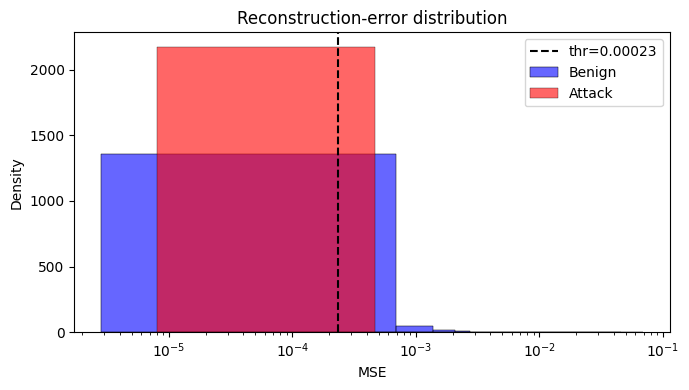

In [12]:
test_err = np.mean((auto.predict(X_test) - X_test)**2, axis=1)
y_pred   = (test_err > threshold).astype(int)

print("\nClassification Report (Benign = 0, Attack = 1):")
print(classification_report(y_test_bin, y_pred, digits=3))

print("Confusion-Matrix:")
print(confusion_matrix(y_test_bin, y_pred))

# Optional: plot error distributions
plt.figure(figsize=(7,4))
sns.histplot(test_err[y_test_bin==0], bins=100, stat="density",
             label="Benign", color="blue", alpha=0.6)
sns.histplot(test_err[y_test_bin==1], bins=100, stat="density",
             label="Attack", color="red" , alpha=0.6)
plt.axvline(threshold, ls="--", c="k", label=f"thr={threshold:.2g}")
plt.xscale("log"); plt.legend(); plt.title("Reconstruction-error distribution")
plt.xlabel("MSE"); plt.tight_layout(); plt.show()